In [400]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from itertools import combinations
from collections import Counter
from zipfile import ZipFile
import os
from networkx.algorithms.community import girvan_newman
import json
import requests
import re
import matplotlib.patches as mpatches
import itertools
import matplotlib.cm as cm


In [401]:
# Reusable variables
seed = 33
d_color = "#4152ec"
colors = ['#292929', '#768695', d_color, '#50dcff', '#ffa30e', '#ffe72f', '#f43131', '#ff9ad2', '#2ca02c', '#a8ee72', '#795133', '#c98d66']

In [403]:
# used csv files, linking it with their source zip files
csv_to_zip_source = {
    "Netflix_Dataset_Movie.csv": "zip_sources/Netflix_Dataset_Movie.csv.zip",
    "Netflix_Dataset_Rating.csv": "zip_sources/Netflix_Dataset_Rating.csv.zip",
    "tmdb_5000_credits.csv": "zip_sources/tmdb.zip",
    "tmdb_5000_movies.csv": "zip_sources/tmdb.zip"
}

csv_file_names = list(csv_to_zip_source.keys())

# common data directory path
data_dir = "./data"

# if directory does not exist, create it
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

# check if all .csv can be found in data directory, if not we extract it from corresponding zip source
for csv_file_name in csv_file_names:
    if not os.path.exists(f"{data_dir}/{csv_file_name}"):
        # if it is not found
        zip_source_file_name = csv_to_zip_source[csv_file_name]
        print(f"❗'{csv_file_name}' does not exist in the '{data_dir}' directory, extracting it from zip file '{zip_source_file_name}'...")
        with ZipFile(zip_source_file_name, 'r') as zip:
            zip.extract(csv_file_name, path=data_dir)
            print(f"Done extracting {csv_file_name} from {zip_source_file_name}")
    else:
        # csv exists and found, let user know
        print(f"'{data_dir}/{csv_file_name}' exists ✅")
    print("---")

'./data/Netflix_Dataset_Movie.csv' exists ✅
---
'./data/Netflix_Dataset_Rating.csv' exists ✅
---
'./data/tmdb_5000_credits.csv' exists ✅
---
'./data/tmdb_5000_movies.csv' exists ✅
---


In [404]:
movies = pd.read_csv(f"{data_dir}/Netflix_Dataset_Movie.csv")
ratings = pd.read_csv(f"{data_dir}/Netflix_Dataset_Rating.csv")
credits = pd.read_csv(f"{data_dir}/tmdb_5000_credits.csv")
tmdb_movies = pd.read_csv(f"{data_dir}/tmdb_5000_movies.csv")

In [409]:
df_movies = movies[movies.Name.isin(credits.title)]
df_movies_2000 = df_movies[df_movies['Year'] >= 2000]

,Movie_ID,Year,Name
29,30,2003,Something's Gotta Give
88,89,2000,Chain of Command
147,148,2001,Sweet November
166,167,2004,The Chorus
180,181,2004,The Last Shot
...,...,...,...
17696,17697,2004,New York Minute
17702,17703,2003,Hulk
17706,17707,2004,Latter Days
17742,17743,2003,Better Luck Tomorrow


In [411]:
df_movies_ids = df_movies['Movie_ID'].values
df_credits = credits[credits['movie_id'].isin(df_movies_ids)]

,movie_id,title,cast,crew
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
17,1865,Pirates of the Caribbean: On Stranger Tides,"[{""cast_id"": 15, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""566b4f54c3a3683f56005151"", ""de..."
30,558,Spider-Man 2,"[{""cast_id"": 33, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f8015039"", ""de..."
32,12155,Alice in Wonderland,"[{""cast_id"": 7, ""character"": ""Alice Kingsleigh...","[{""credit_id"": ""52fe44c09251416c7503fbc3"", ""de..."
68,1726,Iron Man,"[{""cast_id"": 19, ""character"": ""Tony Stark / Ir...","[{""credit_id"": ""52fe4311c3a36847f8037f21"", ""de..."
...,...,...,...,...
4454,11446,Welcome to the Dollhouse,"[{""cast_id"": 1, ""character"": ""Dawn Wiener"", ""c...","[{""credit_id"": ""52fe44419251416c7502e401"", ""de..."
4517,14358,Mad Hot Ballroom,[],"[{""credit_id"": ""52fe45ea9251416c75066cd9"", ""de..."
4726,9821,The Mighty,"[{""cast_id"": 1, ""character"": ""Gwen Dillon"", ""c...","[{""credit_id"": ""52fe4534c3a36847f80c1f2d"", ""de..."
4738,473,Pi,"[{""cast_id"": 5, ""character"": ""Maximillian Cohe...","[{""credit_id"": ""52fe4247c3a36847f8011f69"", ""de..."


---
# **Movie network**
---
- **Nodes**: Movies
- **Edges**: Two movies are connected if they have a common actor in their top 5 staring actors.

## **Network**

In [420]:
G_movies = nx.Graph()

# Iterate over each row in the credits dataframe
for index, row in df_credits.iterrows():
    cast = json.loads(row['cast']) # Parse the cast column (=JSON string)
    
    # Get names of the first 10 actors
    actors = [actor['name'] for actor in cast[:5]]
    G_movies.add_node(row['title'], actors=actors)

# Iterate over all pairs of movies
for movie1, movie2 in combinations(G_movies.nodes, 2):
    # Actors for each movie
    actors1 = G_movies.nodes[movie1]['actors']
    actors2 = G_movies.nodes[movie2]['actors']
    
    # Number of common actors
    common_actors = len(set(actors1) & set(actors2))
    
    # If they have at least x common actors, add an edge between them
    if common_actors >= 1:
        G_movies.add_edge(movie1, movie2)


In [421]:
# Largest connected component
largest_cc = max(nx.connected_components(G_movies), key=len)
G_movies_lcc = G_movies.subgraph(largest_cc)

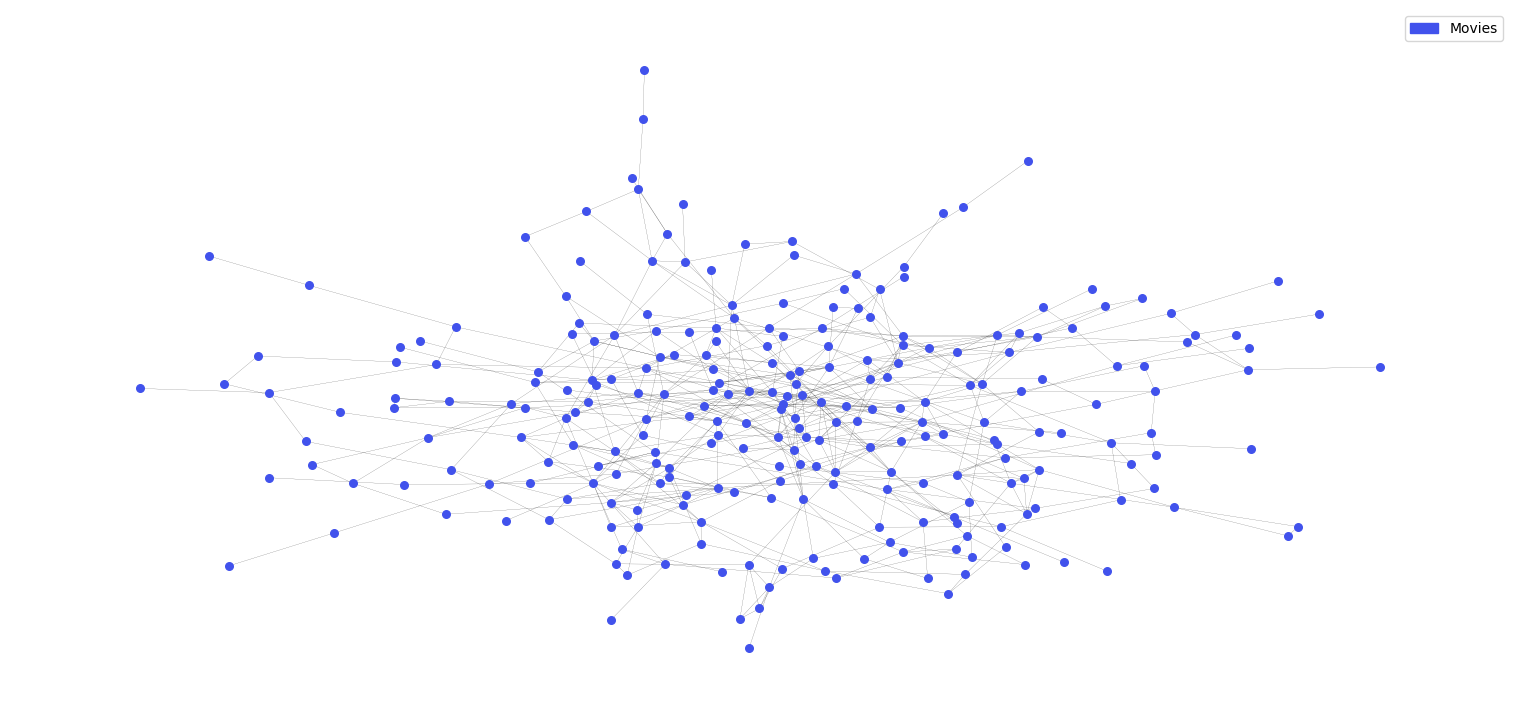

In [422]:
# Layout
plt.figure(figsize=(15, 7))
pos = nx.spring_layout(G_movies_lcc)

# Draw network
nx.draw(G_movies_lcc, pos, node_color=d_color, edge_color='black', with_labels=False, node_size=30, width=0.1)

# Legend
movies_patch = mpatches.Patch(color=d_color, label='Movies')
plt.legend(handles=[movies_patch])

plt.show()

In [423]:
n, m = len(G_movies.nodes()), len(G_movies.edges())
print('Nb nodes: n =', n)
print('Nb edges: m =', m)

Nb nodes: n = 323
Nb edges: m = 548


## **Communities**

In [436]:
# comparing with NetworkX
nx_communities = nx.algorithms.centrality.edge_betweenness_centrality(G_movies)

nx_girvan_newman = nx.algorithms.community.centrality.girvan_newman(G_movies)

nx_best_community = tuple(sorted(c) for c in next(nx_girvan_newman))
print('Comparing best communities:')
print('\t- NetworkX:', nx_best_community)

nx_modularity_G = nx.algorithms.community.quality.modularity(G_movies, nx_best_community)
print('\nComparing Modularity:')
print('\t- NetworkX:', nx_modularity_G)

Comparing best communities:
	- NetworkX: (['10th & Wolf', '15 Minutes', '21', '9', 'A Prairie Home Companion', 'A View to a Kill', 'About Schmidt', 'Alice in Wonderland', 'Alien', 'Appaloosa', 'Arlington Road', 'At First Sight', 'Austin Powers in Goldmember', 'Babylon A.D.', 'Basic Instinct 2', 'Behind Enemy Lines', 'Beyond Borders', 'Big Trouble in Little China', 'Boogie Nights', 'Breakdown', 'Broken Arrow', 'Cape Fear', "Captain Corelli's Mandolin", 'Casino', 'Charlie Bartlett', 'Charlie and the Chocolate Factory', 'Click', 'Come Early Morning', 'Contact', 'Control', 'Copying Beethoven', 'Cutthroat Island', 'D-Tox', 'Dangerous Liaisons', 'Dark City', 'De-Lovely', 'Dracula', 'Dracula 2000', 'DragonHeart', 'Dragonball Evolution', 'Elizabethtown', 'Evan Almighty', 'Fast Times at Ridgemont High', 'Fifty Dead Men Walking', 'Fight Club', 'Find Me Guilty', 'Frailty', 'Freedom Writers', 'G.I. Joe: The Rise of Cobra', 'Garden State', 'Get Smart', 'Goldfinger', 'Gone in Sixty Seconds', 'Grease

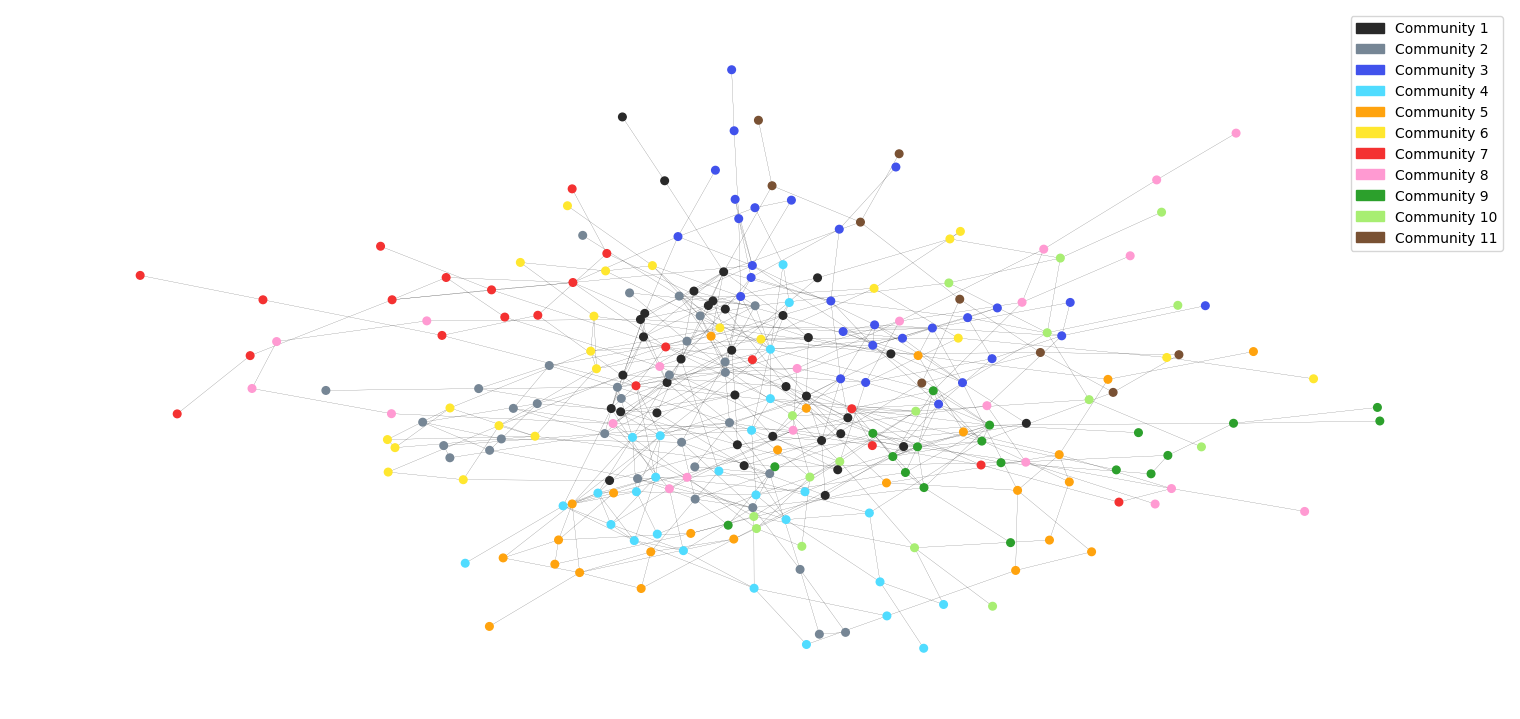

In [437]:
# Communities
communities = nx.algorithms.community.greedy_modularity_communities(G_movies_lcc)

# Plot
plt.figure(figsize=(15, 7))
pos = nx.spring_layout(G_movies_lcc)
color_map = {node: colors[i % len(colors)] for i, community in enumerate(communities) for node in community}
nx.draw(G_movies_lcc, pos, node_color=[color_map[node] for node in G_movies_lcc.nodes], edge_color='black', with_labels=False, node_size=30, width=0.1)
patches = [mpatches.Patch(color=colors[i % len(colors)], label=f'Community {i+1}') for i in range(len(communities))]
plt.legend(handles=patches)
plt.show()


In [438]:
# Number of Movies in Each Community
for i, community in enumerate(communities, start=1):
    print(f'Community {i}: \t {len(community)} movies')

Community 1: 	 35 movies
Community 2: 	 32 movies
Community 3: 	 29 movies
Community 4: 	 27 movies
Community 5: 	 25 movies
Community 6: 	 22 movies
Community 7: 	 21 movies
Community 8: 	 21 movies
Community 9: 	 19 movies
Community 10: 	 16 movies
Community 11: 	 9 movies


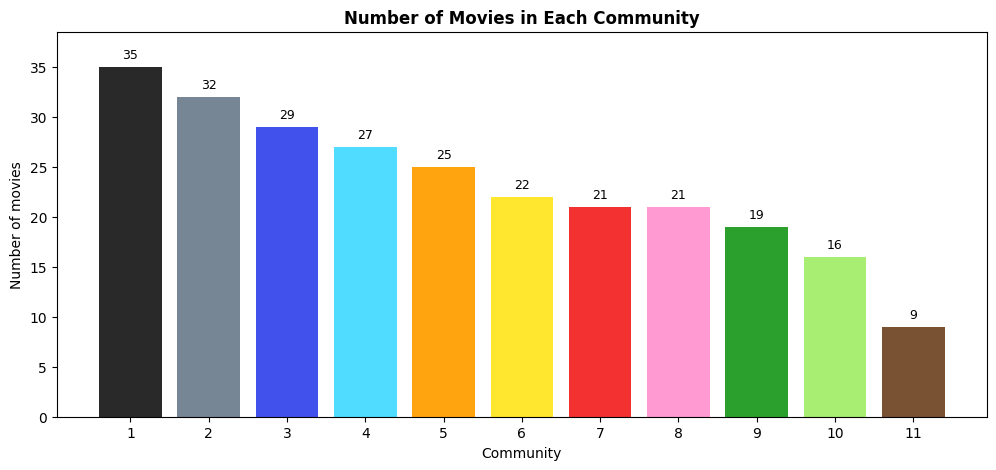

In [439]:
# Number of movies in each community
num_movies = [len(community) for community in communities]

# Histogram
plt.figure(figsize=(12, 5))
bars = plt.bar(range(1, len(communities) + 1), num_movies, color=[colors[i % len(colors)] for i in range(len(communities))])
plt.xticks(range(1, len(communities) + 1))
plt.ylim(0, max(num_movies) + (max(num_movies)/10))
plt.xlabel('Community')
plt.ylabel('Number of movies')
plt.title('Number of Movies in Each Community', fontweight='bold')

# Add the precise number of movies above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom', fontsize=9)

plt.show()


In [440]:
# Number of Movies in Each Community and their titles
for i, community in enumerate(communities, start=1):
    print(f'Community {i}:')
    for movie in community:
        print(f'\t- {movie}')
    print('\n')


Community 1:
	- Modern Problems
	- O
	- The American President
	- Enemy of the State
	- Out of Time
	- Three Kingdoms: Resurrection of the Dragon
	- Wonder Boys
	- Caddyshack
	- Die Hard 2
	- Gigli
	- The Beastmaster
	- Unbreakable
	- Selena
	- Welcome to Mooseport
	- Resurrecting the Champ
	- DodgeBall: A True Underdog Story
	- The Informant!
	- The Prince & Me
	- Dogma
	- Wyatt Earp
	- The Rainmaker
	- Music and Lyrics
	- Madagascar: Escape 2 Africa
	- Go
	- September Dawn
	- Behind Enemy Lines
	- Ali
	- The Great Debaters
	- Live Free or Die Hard
	- Firestarter
	- Menace II Society
	- The Siege
	- Men in Black
	- The Cell
	- Stuck on You


Community 2:
	- Peggy Sue Got Married
	- Sky Captain and the World of Tomorrow
	- Heaven's Gate
	- Owning Mahowny
	- The Man with the Golden Gun
	- Contact
	- Bad Santa
	- 10th & Wolf
	- The Brothers McMullen
	- The Secret Life of Bees
	- Captain Corelli's Mandolin
	- Beyond Borders
	- 15 Minutes
	- Alien
	- Cutthroat Island
	- Life or Something L

## **Degrees**
- A high degree count for a movie means that the movie shares a significant number of actors with many other movies. This means that many of the actors in the movie have also acted in a large number of other movies in the network. This could indicate that the movie has a well-known or versatile cast.

In [471]:
# Both old and new users
degrees = G_movies.degree()
top_10_movies_degree = sorted(degrees, key=lambda x: x[1], reverse=True)[:10]
for movie, degree in top_10_movies_degree:
    print(f'{movie}: {degree}')

Sleepers: 12
9: 12
Boogie Nights: 12
The Perfect Storm: 11
The Rainmaker: 11
Contact: 10
Meet Joe Black: 10
Captain Corelli's Mandolin: 10
Casino: 10
The Lost World: Jurassic Park: 9


## **Betweenness centrality**
- Betweenness centrality is a measure of a node’s centrality in a network. It is equal to the number of shortest paths from all vertices to all others that pass through that node. A higher betweenness centrality generally means that a node is more central in the network.
- Maybe use for new users (no movies seen yet). The movies with high betweenness centrality would be good for new users as the movies are connected to many other movies in the network through shared actors. 

In [446]:
# Use for new users maybe
centrality = nx.betweenness_centrality(G_movies)
top_10_movies_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for movie, centrality in top_10_movies_centrality:
    print(f'{movie}: {centrality}')

The Lost World: Jurassic Park: 0.04843187169899485
9: 0.04754404088236613
Sleepers: 0.04751200008510016
Boogie Nights: 0.044052753611401416
The Rainmaker: 0.04378652254225485
Meet Joe Black: 0.03748729345643576
Pollock: 0.036059306012188076
Captain Corelli's Mandolin: 0.03372307113496123
Casino: 0.03292077180437277
Sahara: 0.03203947216128977


## **Recommend movies based on communites**
- Sort these movies based on number of common actors

In [ ]:
# Should have seen at least one movie. Recommend based on latest seen movie.
def top_10_movies_common_actors(movie_title, G_movies):
    given_movie_actors = set(G_movies.nodes[movie_title]['actors'])

    # Number of common actors for each movie
    common_actors = {movie: len(given_movie_actors & set(G_movies.nodes[movie]['actors'])) for movie in G_movies.nodes if movie != movie_title}
    common_actors = {movie: actors for movie, actors in common_actors.items() if actors > 0}
    if not common_actors:
        print(f'No movies found with common actors to "{movie_title}".')
        return []
    sorted_movies = sorted(common_actors.items(), key=lambda x: x[1], reverse=True)
    top_movies = sorted_movies[:10] 

    return top_movies

In [514]:
def print_movie_community(movie_title, communities):
    for i, community in enumerate(communities, start=1):
        if movie_title in community:
            print(f'"{movie_title}" is in Community {i}. These are the top 10 recommended movies with common actors:')
            sorted_movies = top_10_movies_common_actors(movie_title, G_movies)
            sorted_movies = [movie for movie in sorted_movies if movie[0] in community]
            for movie, common_actors in sorted_movies:
                print(f'\t- {movie}: {common_actors}')
            if len(sorted_movies) < 10:
                print(f'\nNote: There are only {len(sorted_movies)} movies with common actors to "{movie_title}".')
            break
    else:
        print(f'"{movie_title}" is not found in any community.')


In [515]:
print_movie_community("Basic Instinct 2", communities)

"Basic Instinct 2" is in Community 3. These are the top 10 recommended movies with common actors:
	- DragonHeart: 1
	- Casino: 1
	- Babylon A.D.: 1
	- The Boy in the Striped Pyjamas: 1
	- The Mighty: 1

Note: There are only 5 movies with common actors to "Basic Instinct 2".
